In [1]:

from scipy.stats import pearsonr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def tpr(x,y):
    return (x*y).sum() / y.sum()

def tnr(x,y):
    return ((1-x)*(1-y)).sum() / (1-y).sum()

In [3]:
models = ["anthropic_claude-3-5-sonnet-20240620","openai_gpt-4-0613","google_gemini-1.5-pro-001","meta_llama-3-70b","meta_llama-2-7b"]

In [4]:
def get_all_targets():
    return np.load("Data/targets_mmlu.npy")

In [5]:
def get_all_predictions(model):
    if model=="llama3.1":
        model = "llama_405B_numeric"
    return np.load("Data/"+model + "_predictions_mmlu.npy")

In [6]:
get_all_targets().shape

(14042, 4)

In [22]:
preds = get_all_predictions("llama3.1")

targets = get_all_targets()
for model in models:
    print(model)
    gpt = get_all_predictions(model)

    scores = (gpt*preds).sum(1)

    real_acc = (targets*gpt).sum(1)

    print("baseline var", real_acc.var())

    print("ppi var", (scores-real_acc).var())

    lam = np.cov(real_acc,scores)[0,1] / np.var(scores)

    print("ppi++ var", (lam*scores-real_acc).var())

    coarse = np.round(scores/2,decimals=1)*2
    #print("counts", np.unique(coarse,return_counts=True))

    print("ppi_coarse var", (coarse-real_acc).var())

    lam_coarse = np.cov(real_acc,coarse)[0,1] / np.var(coarse)

    print("ppi++ var coarse", (lam_coarse*coarse-real_acc).var())

    coarse_calibrated = coarse.copy()

    for value in np.unique(coarse):
        coarse_calibrated[coarse==value] = real_acc[coarse==value].mean()
        #print(value,real_acc[coarse==value].mean())
    print("basic strat var", (coarse_calibrated-real_acc).var())

    total_variance = 0.0
    for value in np.unique(coarse):
        prob = (coarse == value).mean()
        conditional_var = real_acc[coarse == value].var()
        total_variance += prob*conditional_var
        
    print("basic strat var alt", (total_variance))
    
    optimized_variance = 0.0
    for value in np.unique(coarse):
        prob = (coarse == value).mean()
        conditional_std = real_acc[coarse == value].std()
        optimized_variance += prob*conditional_std
        
    optimized_variance = optimized_variance**2
    
    print("neyman strat var alt", (optimized_variance))
    

anthropic_claude-3-5-sonnet-20240620
baseline var 0.11159607733456192
ppi var 0.0914719110337836
ppi++ var 0.08252020258803268
ppi_coarse var 0.09495730218342471
ppi++ var coarse 0.08314227996516704
basic strat var 0.08311946985592207
basic strat var alt 0.08311946985592207
neyman strat var alt 0.062255709586008325
openai_gpt-4-0613
baseline var 0.13417131558505752
ppi var 0.08743322710140392
ppi++ var 0.08425228616462092
ppi_coarse var 0.09064579188553938
ppi++ var coarse 0.08545455954805033
basic strat var 0.08536377357098263
basic strat var alt 0.08536377357098261
neyman strat var alt 0.06413683779532607
google_gemini-1.5-pro-001
baseline var 0.14175047141725372
ppi var 0.08632067074230355
ppi++ var 0.08320801589950304
ppi_coarse var 0.08923108875501803
ppi++ var coarse 0.08414464128462343
basic strat var 0.08367091755536868
basic strat var alt 0.08367091755536867
neyman strat var alt 0.06325588583662496
meta_llama-3-70b
baseline var 0.1677557921794873
ppi var 0.0820214832851304
ppi

In [23]:
preds = get_all_predictions("llama3.1")

targets = get_all_targets()

def get_data(model,n=100,k=100,with_replacement=False):
    gpt = get_all_predictions(model)
    f = (gpt*preds).sum(1)
    y = (targets*gpt).sum(1)
    assert not with_replacement, "Not implemented"
    keys = np.random.random((k, len(f)))
    
    idx = np.argpartition(keys, kth=n-1, axis=1)     # O(k*N)
    sub_idx  = idx[:, :n]
    comp_idx = idx[:, n:]
    
    
    subs_f = np.take(f, sub_idx).T     # shape (k, n)
    comps_f = np.take(f, comp_idx).T
    
    subs_y = np.take(y, sub_idx).T     # shape (k, n)
    

    
    return subs_f,comps_f,subs_y,np.mean(y)


def subsamples_n_k(x, n, k):
    """Return (k, n) array: k independent subsamples of size n from 1D x, each without replacement."""
    x = np.asarray(x)
    m = x.size

    keys = np.random.random((k, m))
    idx = np.argpartition(keys, n - 1, axis=1)[:, :n]
    return x[idx].T

def shuffled_copies(a, k):
    a = np.asarray(a)
    n = a.shape[0]

    keys = np.random.random((n, k))          # independent random keys per (i, col)
    idx = np.argsort(keys, axis=0)     # permutation indices per column
    return a[idx]   


def baseline(model, n=100, k=1000,with_replacement=False):
    
     
    gpt = get_all_predictions(model)
    f = (gpt*preds).sum(1)
    y = (targets*gpt).sum(1)
    
    f_l, f_u, y_l ,target = get_data(model,n=n,k=k,with_replacement=with_replacement)
    
    
    sum_y_l  = (y_l).sum(axis=0)
    mean_y_l = sum_y_l / n
    
    est = mean_y_l
    
    return np.mean((est-target)**2)*n 

def ppi_k(model, n=100, k=1000,with_replacement=False):
    
    gpt = get_all_predictions(model)
    f = (gpt*preds).sum(1)
    y = (targets*gpt).sum(1)
    
    f_l, f_u, y_l ,target = get_data(model,n=n,k=k,with_replacement=with_replacement)

    sum_y_l  = (y_l).sum(axis=0)
    sum_f_l  = (f_l).sum(axis=0)
    sum_yf_l = (y_l * f_l).sum(axis=0)

    mean_y_l = sum_y_l / n
    mean_f_l = sum_f_l / n
    
    mean_f_u = f_u.mean()
    var_f_u = f_u.var()

    # Covariance on labeled set: matches np.cov(yl, fl)[0,1] default ddof=1
    cov_yf_l = (sum_yf_l - n * mean_y_l * mean_f_l) / (n - 1)
    denom = var_f_u

    lam = np.where(np.abs(denom) > 0.0, cov_yf_l / denom, 0.0)
    est = mean_y_l + lam * (mean_f_u - mean_f_l)
 
    return np.mean((est-target)**2)*n 





def bound(sd,step,weight,beta):
    return weight * (sd + 2*beta / np.sqrt(step)) / step 

def adaptive_strat_k(model,n=100,k=1024,n_strata=6,with_replacement=False,beta="default"):
    
    gpt = get_all_predictions(model)
    f = (gpt*preds).sum(1)
    y = (targets*gpt).sum(1)
    
    if beta == "default":
        beta = np.sqrt(4.5*np.log(n))
        
    coarse = np.clip(np.rint(f * (n_strata-1)) / (n_strata-1), 0.0, 1.0)
        
    #Warmup?!
    #Idea: Every step does index-based stratum queries (How to parallelize?)
    #Then: Batched calculations of the exploration indexes 
    
    masks = [coarse == value for value in np.unique(coarse)]
    #assert min([mask.sum() for mask in masks]) > n or with_replacement, str(n)+"  "+str(min([mask.sum() for mask in masks]))
    weights = [mask.sum() / len(f)  for mask in masks]
    
    #For each arm: pre-sample draws without replacement
    #rs = [np.random.choice(y[masks[i]], size = (n,k) )  for i in range(len(masks)) ]
    if with_replacement:
        rs = [np.random.choice(y[masks[i]], size = (n,k) )  for i in range(len(masks)) ]
    else:
        rs = [shuffled_copies(y[masks[i]],k)  for i in range(len(masks)) ]
        
    # Start by sampling twice per arm 
    ns = np.zeros((len(masks),k),dtype=int) + 2
    
    sums = [rs[i][:2].sum(0) for i in range(len(masks))]
    
    idx = np.arange(k)
    
    for _ in range(max(n - 2*len(masks), 0)):
        stds = [np.sqrt((sums[i] - (sums[i])**2 / ns[i]) / (ns[i]-1)) for i in range(len(masks))]
        bs = [bound(stds[i], ns[i], weights[i], beta)  for i in range(len(masks))]
        best_b = np.argmax(np.stack(bs),0) #One per parallel run!
        
        chooses = [best_b == i for i in range(len(masks))]
        
        for i in range(len(masks)):
            
            if chooses[i].any():
                index = idx[chooses[i]]
                sums[i][index] += rs[i][ns[i][index],index]
                ns[i][index] += 1
    
    means = [sums[i]/ns[i] for i in range(len(masks))]
    est = np.stack([weights[i]*means[i] for i in range(len(masks))]).sum(0)
    #print(sum([sum(ns[i]) for i in range(len(masks))]))
    return np.mean((est-np.mean(y))**2)*n 

def simple_strat_k(model,n=100,k=1024,n_strata=6,with_replacement=False):
    
    gpt = get_all_predictions(model)
    f = (gpt*preds).sum(1)
    y = (targets*gpt).sum(1)
        
    coarse = np.clip(np.rint(f * (n_strata-1)) / (n_strata-1), 0.0, 1.0)
    
    masks = [coarse == value for value in np.unique(coarse)]
    
   
    weights = [mask.sum() / len(f)  for mask in masks]
    samples = [np.floor(n*weight) for weight in weights]
    assert np.all([masks[i].sum() >= samples[i] for i in range(len(masks))]) or with_replacement
    , str(n)+"  "+str(min([mask.sum() for mask in masks]))
    
    
    if with_replacement:
        rs = [np.random.choice(y[masks[i]], size = (n,k) )  for i in range(len(masks)) ]
    else:
        rs = [shuffled_copies(y[masks[i]],k)  for i in range(len(masks)) ]
    i=0
    
    means = [rs[i][:int(samples[i]),:].sum(0)/samples[i] for i in range(len(masks))]
    
    est = np.stack([weights[i]*means[i] for i in range(len(masks))]).sum(0)
    #print(sum([sum(ns[i]) for i in range(len(masks))]))
    return np.mean((est-np.mean(y))**2)*n 



In [24]:
from matplotlib import pyplot as plt
def plot(model,ax,ns=[33,100,330,1000],k=1000,wr=False):
    base = []
    ppi = []
    strat_rounded_6 = []
    adaptive_strat_6 = []
    strat_rounded_11 = []
    adaptive_strat_11 = []
    adaptive_strat_21 = []
    adaptive_strat_101 = []
    
    for n in ns:
        base.append(baseline(model,n=n,k=k))
        ppi.append(ppi_k(model,n=n,k=k))
        strat_rounded_6.append(simple_strat_k(model,n=n,k=k,with_replacement=wr))
        adaptive_strat_6.append(adaptive_strat_k(model,n=n,k=k,with_replacement=wr))
        
        strat_rounded_11.append(simple_strat_k(model,n=n,k=k,with_replacement=wr,n_strata=11))
        adaptive_strat_11.append(adaptive_strat_k(model,n=n,k=k,with_replacement=wr,n_strata=11))
        adaptive_strat_21.append(adaptive_strat_k(model,n=n,k=k,with_replacement=wr,n_strata=21))
        adaptive_strat_101.append(adaptive_strat_k(model,n=n,k=k,with_replacement=wr,n_strata=101))
        
    ax.plot(ns,base,color="black") 
    ax.plot(ns,ppi,color="green")
    ax.plot(ns,strat_rounded_6,color="orange")
    ax.plot(ns,adaptive_strat_6,color="red")
    
    ax.plot(ns,strat_rounded_11,color="orange",linestyle="--")
    ax.plot(ns,adaptive_strat_11,color="red",linestyle="--")
    ax.plot(ns,adaptive_strat_21,color="red",linestyle="-.")
    ax.plot(ns,adaptive_strat_101,color="red",linestyle=":")
    


    ax.set_title(model)
    ax.set_ylim(0,None)

    

In [ ]:
fig,axes = plt.subplots(1,5,figsize=(15,3))

for i,model in enumerate(models):
    plot(model,axes[i],k=1000,ns=[33,100,330,1000,3300])
    
    
    
plt.legend(["Naive","PPI++","Stratified (6)","Adaptive (6)","Stratified (11)","Adaptive (11)","Adaptive (21)","Adaptive (101)"],bbox_to_anchor=(1,1))
fig.supxlabel("Budget n")
fig.supylabel("n * MSE")

fig.tight_layout()

plt.show()

/var/folders/ck/kgc5rjgn1s76_fwbdngtj5cm0002mx/T/ipykernel_61501/1321673050.py:171: RuntimeWarning: invalid value encountered in divide
  means = [rs[i][:int(samples[i]),:].sum(0)/samples[i] for i in range(len(masks))]


In [155]:
n_strata = 11

In [156]:
f = np.arange(0,1,0.001)

In [157]:
coarse = np.clip(np.rint(f * n_strata) / n_strata, 0.0, 1.0)

In [158]:
coarse

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090

/var/folders/ck/kgc5rjgn1s76_fwbdngtj5cm0002mx/T/ipykernel_87345/1349820748.py:160: RuntimeWarning: invalid value encountered in divide
  means = [rs[i][:int(samples[i]),:].sum(0)/samples[i] for i in range(len(masks))]


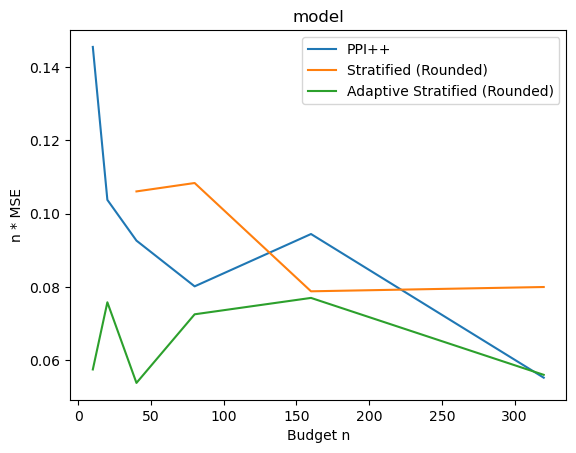

In [ ]:
[0.23495, 0.367829375, 0.51731375, 0.704148125, 0.84508375, 0.97980125]

In [33]:
ppi_k("openai_gpt-4-0613",n=1000,k=10000)

0.07833793075247364

In [34]:
ppi_k("openai_gpt-4-0613",n=10000,k=10000)

0.024819560576118168

In [24]:
ppi_k("openai_gpt-4-0613",n=500,k=10000)

0.08205263173521983

In [23]:
simple_strat_k("openai_gpt-4-0613",n=500,k=10000,with_replacement=True)

0.08502359679802624

In [26]:
adaptive_strat_k("openai_gpt-4-0613",n=500,k=10000,with_replacement=True)

0.0664146133417676

In [18]:
simple_strat_k("openai_gpt-4-0613",n=500,k=100,with_replacement=True)

0.12456298790327144

In [436]:
simple_strat_k("openai_gpt-4-0613",n=5000,k=10000,with_replacement=True)

0.1096477011963947

In [441]:
simple_strat_k("openai_gpt-4-0613",n=100000,k=10000,with_replacement=True)

[41796.0, 9685.0, 4871.0, 3945.0, 6224.0, 33478.0] 99999.0


0.11687029694023995

In [435]:
adaptive_strat_k("openai_gpt-4-0613",n=5000,k=10000,with_replacement=True,beta=1)

0.0995601266908874

In [372]:
adaptive_strat_k("openai_gpt-4-0613",n=500,k=10000,with_replacement=True)

5000000


0.10464299198893447

In [373]:
adaptive_strat_k("openai_gpt-4-0613",n=5000,k=10000,with_replacement=True,beta=0.1)

50000000


0.11552519524061626

In [374]:
adaptive_strat_k("openai_gpt-4-0613",n=5000,k=10000,with_replacement=True,beta=10000)

50000000


0.10499665332734748

7.197788868282122

In [343]:
adaptive_strat_k("openai_gpt-4-0613",n=500,k=100000,with_replacement=False)

50000000


0.11586343571533503

In [314]:
adaptive_strat_k("openai_gpt-4-0613",n=2500,k=100000)

ValueError: kth(=2499) out of bounds (1360)

0.08183130734205121

In [298]:
adaptive_strat_k("openai_gpt-4-0613",n=1000,k=100000)

0.10382122057835604

In [299]:
adaptive_strat_k("openai_gpt-4-0613",n=100,k=100000)

0.1054124020730934

In [300]:
adaptive_strat_k("openai_gpt-4-0613",n=2000,k=100000)

0.10230171868913028

In [200]:
get_data("openai_gpt-4-0613",n=1000,k=1000)[2].mean()

0.840001

In [177]:
k = 100
gpt = get_all_predictions(model)
f = (gpt*preds).sum(1)
y = (targets*gpt).sum(1)

keys = np.random.random((k, len(f)))

In [178]:
keys

array([[0.9589697 , 0.43654963, 0.4766333 , ..., 0.00928845, 0.65295865,
        0.49754888],
       [0.94539511, 0.91944551, 0.03368506, ..., 0.24876829, 0.8031735 ,
        0.70304516],
       [0.40751404, 0.66162821, 0.77103767, ..., 0.28639117, 0.09274373,
        0.826876  ],
       ...,
       [0.21765627, 0.62486226, 0.06359377, ..., 0.65611888, 0.39641695,
        0.9868989 ],
       [0.04437756, 0.13102996, 0.43472534, ..., 0.44152294, 0.40107758,
        0.8306792 ],
       [0.93250132, 0.95338683, 0.0904416 , ..., 0.00534321, 0.54382118,
        0.8392931 ]])

In [ ]:
#Noticeable gains with 1000 strata... But that's not really realistic?! 

In [163]:


def get_acc(model):
    gpt = get_all_predictions(model)
    real_acc = (targets*gpt).sum(1)
    return np.mean(real_acc)
    

In [69]:
coarse-coarse_calibrated

array([-0.12008929, -0.0534965 , -0.09869848, ...,  0.01444803,
        0.01444803,  0.01444803])

In [46]:
coarse_calibrated-coarse

array([ 0.00233201,  0.00233075, -0.00131768, ..., -0.01681712,
       -0.01681712, -0.01681712])

In [38]:
coarse

array([0.4, 0.7, 0.5, ..., 1. , 1. , 1. ])

In [14]:
scores.mean()

0.800125907437687

In [15]:
real_acc.mean()

0.8403361344537815

In [8]:
np.corrcoef(scores, (real_acc))[0,1]**2

0.13342947265003496

In [9]:
thresh = 0.975
print(tpr(scores>thresh, real_acc),tnr(scores>thresh, real_acc))

0.8780508474576271 0.508028545941124


In [10]:
real_acc.mean()

0.8403361344537815